In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

# Utils

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

#def get_mnist():
mnist_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lazyprogrammer/data/mnist.csv', header='infer')

if mnist_df.isna().sum().max() == 0:
  print('There is no NA values')
else:
  print(f'There are {mnist_df.isna().sum().max()} NAs' )

mnist_df.head()

Mounted at /content/gdrive/
There is no NA values


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def plot_misclasified_examples(x, true_lables, predicted_lables, n=5, print_misclassified=False, labels=None):
  misclassified_idx = np.where(predicted_lables != true_lables)[0]
  misclassified_random_idxes = np.random.choice(misclassified_idx, n*n)
  plt.figure(figsize=(15,15))
  for i in range(n*n):
      idx = misclassified_random_idxes[i]
      plt.subplot(n,n,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x[idx], cmap='gray')
      if labels==None:
        plt.xlabel("True  %s, Pred: %s" % (true_lables[idx], predicted_lables[idx]))
      else:
        plt.xlabel("True  %s, Pred: %s" % (labels[true_lables[idx]], labels[predicted_lables[idx]]))
  plt.show()

  if print_misclassified:
      if labels==None:
        print(pd.DataFrame({'idx':misclassified_random_idxes,
                        'true':true_lables[misclassified_random_idxes],
                        'pred':predicted_lables[misclassified_random_idxes]}))
      else:
        print(pd.DataFrame({'idx':misclassified_random_idxes,
                        #'true':labels[true_lables[misclassified_random_idxes]],
                        'true':true_lables[misclassified_random_idxes],
                        #'pred':labels[predicted_lables[misclassified_random_idxes]]}))
                        'pred':predicted_lables[misclassified_random_idxes]}))

def plot_examples(x, y, cmap='gray', labels=None):
  plt.figure(figsize=(15,15))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x[i], cmap=cmap)
      if labels==None:
        plt.xlabel(y[i])
      else:
        plt.xlabel(labels[y[i]])
  plt.show()

In [ ]:
def shuffle_pairs(X, Y):
  N = len(X)
  indexes = np.arange(N)
  np.random.shuffle(indexes)
  X = X[indexes]
  Y = Y[indexes]
  return X, Y


def get_mnist_data(should_shuffle = True, should_plot_examples=True):
  mnist_data = mnist_df.copy().values
  if (should_shuffle == True):
    np.random.shuffle(mnist_data)
  Y_mnist = mnist_data[:, 0]
  X_mnist = np.divide(mnist_data[:, 1:], 255.0)
  picture_shape = (28, 28)

  if (should_plot_examples == True):
    plot_examples(X_mnist.reshape((-1, *picture_shape)), Y_mnist, cmap='gray', labels=None)
  return X_mnist, Y_mnist, picture_shape


def get_xor_data(N=200, should_plot_data=True):
    X = np.zeros((N, 2))
    Nq = N // 4
    X[:Nq] = np.random.random((Nq, 2)) / 2 + 0.5 # (0.5-1, 0.5-1)
    X[Nq:2*Nq] = np.random.random((Nq, 2)) / 2 # (0-0.5, 0-0.5)
    X[2*Nq:3*Nq] = np.random.random((Nq, 2)) / 2 + np.array([[0, 0.5]]) # (0-0.5, 0.5-1)
    X[3*Nq:] = np.random.random((Nq, 2)) / 2 + np.array([[0.5, 0]]) # (0.5-1, 0-0.5)
    Y = np.array([0]*(N//2) + [1]*(N//2))

    X, Y = shuffle_pairs(X, Y)

    if (should_plot_data == True):
      plt.figure(figsize=(10,10))
      plt.scatter(X[:,0], X[:,1], c=Y, s=100, alpha=0.5);
      plt.title('Training data plot')
    return X, Y


def get_donut_data(N=200, should_plot_data=True):
    R_inner = 5
    R_outer = 10

    # distance from origin is radius + random normal
    # angle theta is uniformly distributed between (0, 2pi)
    R1 = np.random.randn(N//2) + R_inner
    theta = 2*np.pi*np.random.random(N//2)
    X_inner = np.concatenate([[R1 * np.cos(theta)], [R1 * np.sin(theta)]]).T

    R2 = np.random.randn(N//2) + R_outer
    theta = 2*np.pi*np.random.random(N//2)
    X_outer = np.concatenate([[R2 * np.cos(theta)], [R2 * np.sin(theta)]]).T

    X = np.concatenate([ X_inner, X_outer ])
    Y = np.array([0]*(N//2) + [1]*(N//2))
    
    X, Y = shuffle_pairs(X, Y)

    if (should_plot_data == True):
      plt.figure(figsize=(10,10))
      plt.scatter(X[:,0], X[:,1], c=Y, s=100, alpha=0.5);
      plt.title('Training data plot')
    return X, Y

# Bayes classifier class

## Prior and likelihood detribution modeling for Naive and non-Naive Bayes probability models

In [ ]:
class NaiveGaussian:
  def __init__(self, mu=None, sigma2=None, X=None, smoothing=1e-3):
    if (mu is None):
      self.mu = np.mean(X, axis=0)
    else:
      self.mu = mu

    if (sigma2 is None):
      self.sigma2 = np.var(X, axis=0) + smoothing
    else:
      self.sigma2 = sigma2
    
  def pdf(self, x):
    return multivariate_normal.pdf(x, self.mu, self.sigma2)

  def logpdf(self, x):
    #print('NaiveGaussian self.mu:', self.mu)
    #print('NaiveGaussian self.sigma2:', self.sigma2)
    return multivariate_normal.logpdf(x, mean=self.mu, cov=self.sigma2)


class MultivariateGaussian:
  def __init__(self, mu=None, sigma2=None, X=None, smoothing=1e-3):
    if (mu is None):
      self.mu = np.mean(X, axis=0)
    else:
      self.mu = mu

    if (sigma2 is None):
      D = X.shape[1]
      self.sigma2 = np.cov(X.T) + smoothing * np.eye(D)
    else:
      self.sigma2 = sigma2
    
  def pdf(self, x):
    return multivariate_normal.pdf(x, self.mu, self.sigma2)

  def logpdf(self, x):
    #print('NaiveGaussian self.mu:', self.mu)
    #print('NaiveGaussian self.sigma2:', self.sigma2)
    return multivariate_normal.logpdf(x, mean=self.mu, cov=self.sigma2)
    

class Discrete1D:
  def __init__(self, classes, p=None, X=None):
    self.classes = classes
    N = len(X)
    if (p is None):
      self.p = { c: float(len(X[X==c])) / N for c in self.classes }
    else:
      self.p = p
    
  def pdf(self, x):
    return self.p[x]

  def logpdf(self, x):
    return np.log(self.pdf(x))

## Generic Bayes classifier class

In [ ]:
from scipy.stats import norm
from scipy.stats import multivariate_normal


class BayesClassifier:
  _distibutions_factory_map = {
      'gaussian_naive': lambda X, Y, classes: { c: NaiveGaussian(mu=None, sigma2=None, X=X[Y==c]) for c in classes },
      'gaussian_multivariate': lambda X, Y, classes: { c: MultivariateGaussian(mu=None, sigma2=None, X=X[Y==c]) for c in classes },
      'empirical': lambda X, classes: Discrete1D(classes=classes, p=None, X=X),
  }


  def __init__(self, likelihood_distribution='gaussian_naive', prior_distribution='empirical'):
    self._likelihood_distribution_factory = self._distibutions_factory_map[likelihood_distribution]
    self._prior_distribution_factory = self._distibutions_factory_map[prior_distribution]
    

  def fit(self, X, Y):
    self.classes = np.unique(Y)
    self.likelihood_distributions = self._likelihood_distribution_factory(np.array(X), np.array(Y), self.classes)
    self.prior_distibution = self._prior_distribution_factory(np.array(Y), self.classes)
  
  
  def predict(self, X):
    N = len(X)
    priors = np.zeros((N, len(self.classes)))
    for idx, c in enumerate(self.classes):
      log_prior = self.prior_distibution.logpdf(c)
      log_likelihood = self.likelihood_distributions[c].logpdf(X)
      priors[:,idx] = log_prior + log_likelihood
    return self.classes[np.argmax(priors, axis=1)]


  def score(self, X, Y):
    predictions = self.predict(X)
    return np.mean(predictions == Y)

# Run model utils

In [ ]:
def run_model(X, Y, N=2000, likelihood_distribution='gaussian_naive', prior_distribution='empirical'):
  X_train, X_test = X[:N//2], X[N//2:N]
  Y_train, Y_test = Y[:N//2], Y[N//2:N]

  model = BayesClassifier(likelihood_distribution, prior_distribution)
  
  t0 = datetime.now()
  model.fit(X_train,Y_train)
  print(f'Fitted within {datetime.now()-t0} time')

  t0 = datetime.now()
  acc = model.score(X_train,Y_train)
  print(f'Predicted within {datetime.now()-t0} time with train accuracy={acc}')
    
  t0 = datetime.now()
  acc = model.score(X_test,Y_test)
  print(f'Predicted within {datetime.now()-t0} time with test accuracy={acc}')

# Use KnnClassifier for MNIST

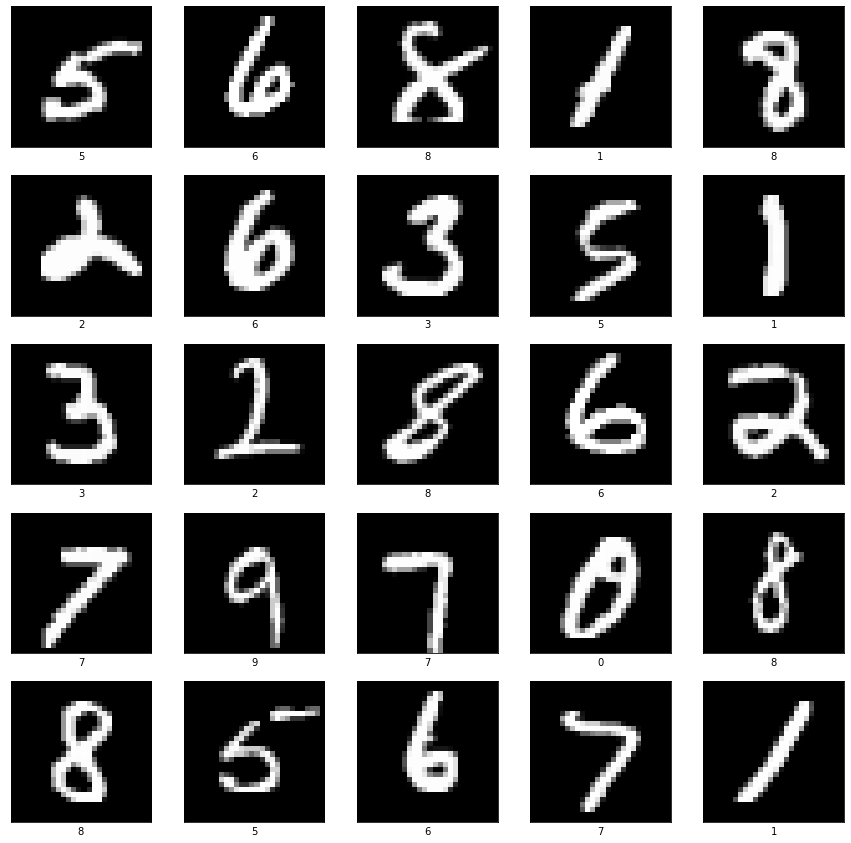

In [ ]:
X, Y, pic_shape = get_mnist_data()

## Naive Bayes

In [ ]:
run_model(X.copy(), Y.copy(), N=50000)

Fitted within 0:00:00.346411 time
Predicted within 0:00:11.780333 time with train accuracy=0.77404
Predicted within 0:00:08.595824 time with test accuracy=0.7641176470588236


## Non-Naive Bayes

In [ ]:
run_model(X.copy(), Y.copy(), N=50000, likelihood_distribution='gaussian_multivariate')

Fitted within 0:00:00.950254 time
Predicted within 0:00:11.881609 time with train accuracy=0.95992
Predicted within 0:00:08.823826 time with test accuracy=0.9051764705882352
